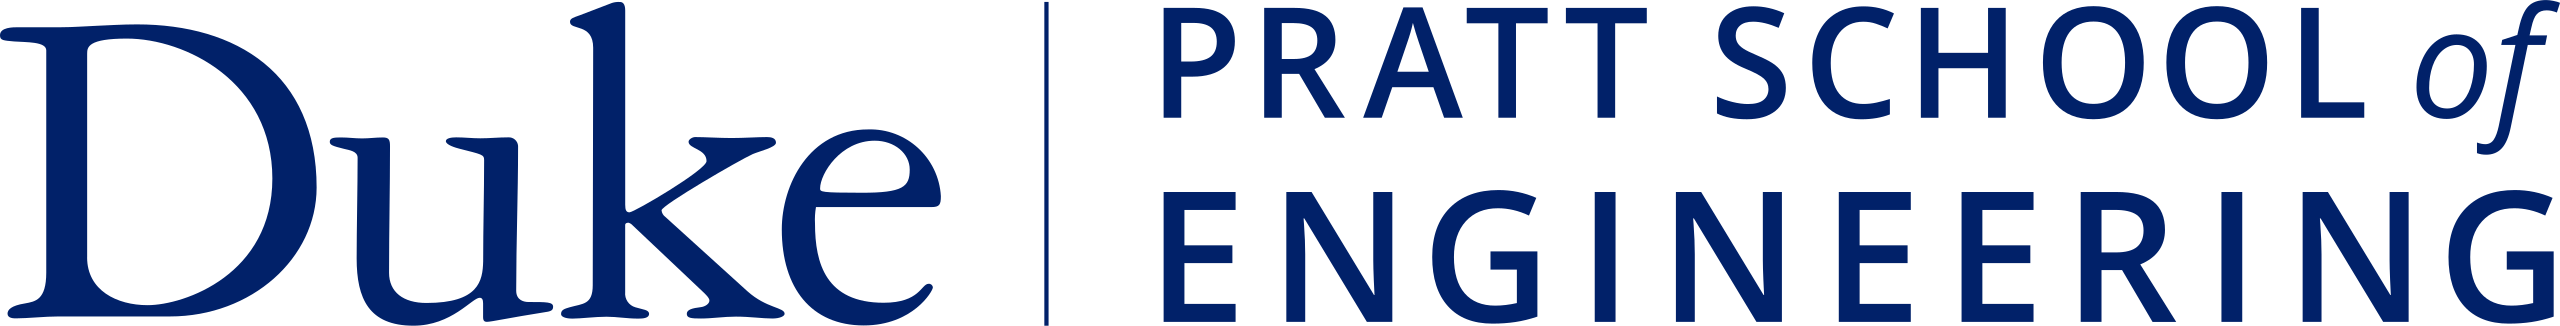

# FINTECH 545 Quantitative Risk Management
## Extra Credit

### Keese Phillips

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keesephillips/quantitative_risk_management/blob/main/Extra_Credit/notebook.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "quantitative_risk_management"
git_path = 'https://github.com/keesephillips/quantitative_risk_management'
!git clone "{git_path}"

notebook_dir = 'Extra_Credit'

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,notebook_dir,'requirements.txt')}"

# Change working directory to location of notebook
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [169]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time

In [ ]:
def binomial_tree(option_type, S, X, r, q, b, T, sigma, Nstep, exercise="european"):
    dt = T / Nstep
    disc = math.exp(-r * dt)

    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    
    p = (math.exp(b * dt) - d) / (u - d)
    
    vvec = [0.0] * (Nstep + 1)
    
    for i in range(Nstep + 1):
        St = S * (u ** i) * (d ** (Nstep - i))
        if option_type.lower() == "call":
            vvec[i] = max(St - X, 0.0)
        else:
            vvec[i] = max(X - St, 0.0)
    
    for j in range(Nstep - 1, -1, -1):
        for i in range(j + 1):
            value = disc * (p * vvec[i + 1] + (1.0 - p) * vvec[i])
            
            if exercise.lower() == "american":
                St_node = S * (u ** i) * (d ** (j - i))
                if option_type.lower() == "call":
                    immediate = max(St_node - X, 0.0)
                else:
                    immediate = max(X - St_node, 0.0)
                vvec[i] = max(value, immediate)
            else:
                vvec[i] = value
    
    return vvec[0]

    
def trinomial_tree(option_type, S, X, r, q, b, T, sigma, Nstep, lamda=1.5, exercise="european"):
    dt = T / Nstep
    disc = math.exp(-r * dt)
    
    u = math.exp(lamda * sigma * math.sqrt(dt))
    d = 1 / u 
    
    pu = 1/(2 * (lamda ** 2)) + ((b - 0.5 * sigma**2) * math.sqrt(dt)) / (2 * lamda * sigma)
    pm = 1 - 1/(lamda ** 2)
    pd = 1/(2 * (lamda ** 2)) - ((b - 0.5 * sigma**2) * math.sqrt(dt)) / (2 * lamda * sigma)
    
    vvec = [0.0] * (2 * Nstep + 1)
    for i in range(len(vvec)):
        ST = S * (d ** Nstep) * (u ** i)
        if option_type == "call":
            vvec[i] = max(ST - X, 0)
        else:
            vvec[i] = max(X - ST, 0)

    for j in range(Nstep-1, -1, -1):
        new_vvec = [0.0] * (2 * j + 1)
        for i in range(2 * j + 1):
            continuation = disc * (pu * vvec[i+2] + pm * vvec[i+1] + pd * vvec[i])
            if exercise.lower() == "american":
                current_S = S * (d ** j) * (u ** i)
                intrinsic = max(current_S - X, 0) if option_type == "call" else max(X - current_S, 0)
                new_vvec[i] = max(continuation, intrinsic)
            else:
                new_vvec[i] = continuation
        vvec = new_vvec

    return vvec[0]

def gbsm(call, S, X, T, r, b, sigma):
    d1 = (np.log(S/X) + (b + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if call:
        return S * np.exp((b-r)*T) * stats.norm.cdf(d1) - X * np.exp(-r*T) * stats.norm.cdf(d2)
    else:
        return X * np.exp(-r*T) * stats.norm.cdf(-d2) - S * np.exp((b-r)*T) * stats.norm.cdf(-d1)

def convergence_test(option_type, S, X, T, r, b, q, sigma, lamda=1.5):
    steps = range(1, 300, 1)
    bi_results = []
    tri_results = []
    bi_times = []
    tri_times = []
    gbsm_time = 0
    tri_conv = 0
    bi_conv = 0
    call_option = True if option_type == "call" else False
    
    true_value = gbsm(call_option, S, X, T, r, b, sigma)
    gbsm_time = end_time - start_time

    
    for n in steps:
        price = trinomial_tree(option_type, S=S, X=X, r=r, q=q, b=b, T=T, sigma=sigma, Nstep=n, lamda=lamda, exercise='european')
        tri_results.append(price)
        if abs(price - true_value) < 0.01 and tri_conv == 0: 
            tri_conv = n
        
        price = binomial_tree(option_type, S=S, X=X, r=r, q=q, b=b,T=T, sigma=sigma, Nstep=n, exercise='european')
        bi_results.append(price)
        if abs(price - true_value) < 0.01 and bi_conv == 0: 
            bi_conv = n
    
    plt.plot(steps, bi_results, color="royalblue",label="Binomial")
    plt.plot(steps, tri_results,color="navy",label="Trinomial")
    plt.axhline(y=true_value, color='black', linestyle='-', label=f"GBMS Price {true_value:.2f}")
    plt.axhline(y=true_value - 0.01, color='red', linestyle='--', label="GBMS Price +/- $0.01")
    plt.axhline(y=true_value + 0.01, color='red', linestyle='--')
    plt.axvline(x=bi_conv, color='royalblue', linestyle='--', label=f"Binomial Convergence @ {bi_conv} Steps")
    plt.axvline(x=tri_conv, color='navy', linestyle='--', label=f"Trinomial Convergence @ {tri_conv} Steps")
    plt.title(f"Convergence to Black-Scholes Value")
    txt=f"{"Call" if call_option else "Put"} Option S0={S:.2f}, K={X:.2f}, ttm={T:.2f}, ivol={sigma:.2f}, λ={lamda:.2f}"
    plt.xlabel(f"Number of Steps\n{txt}")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

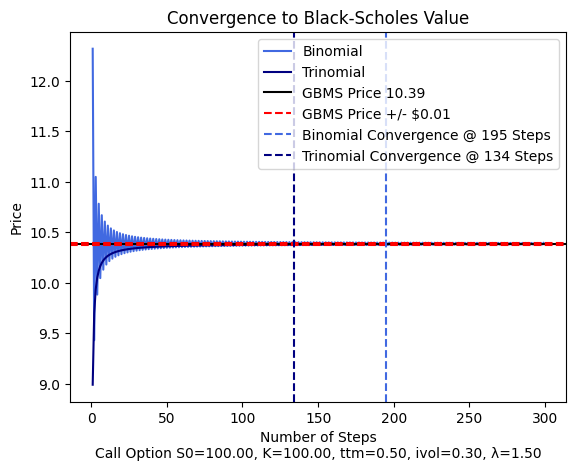

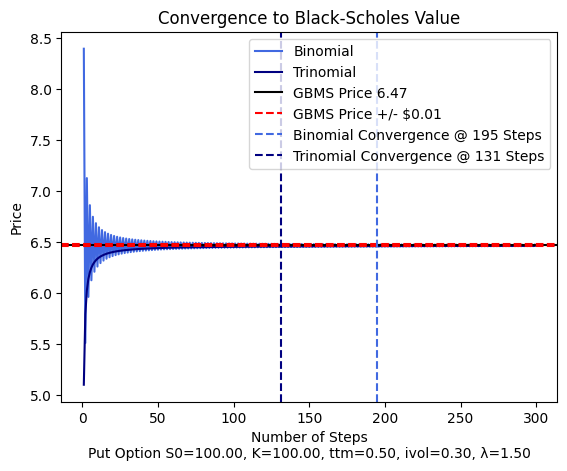

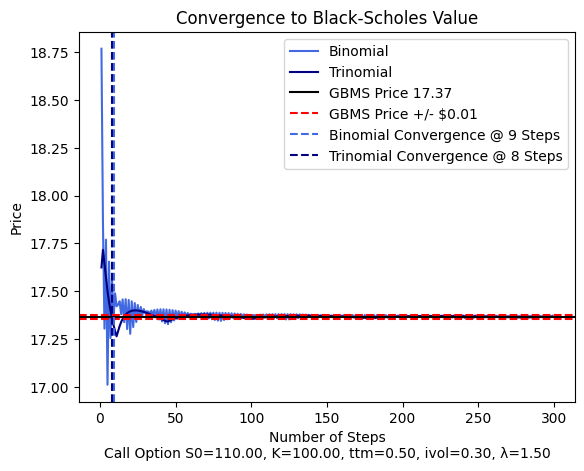

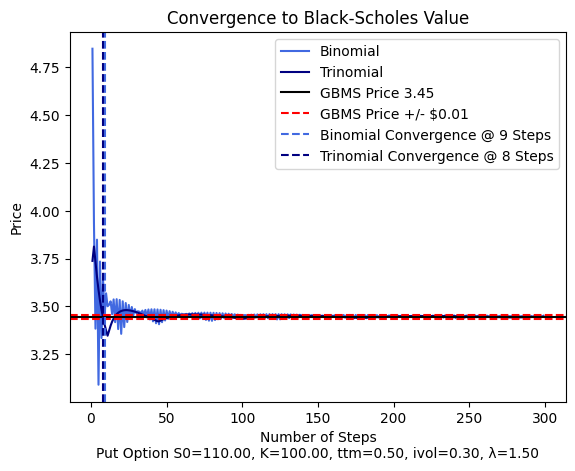

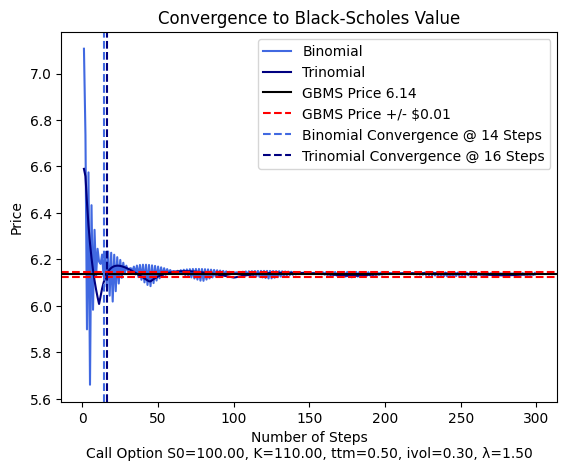

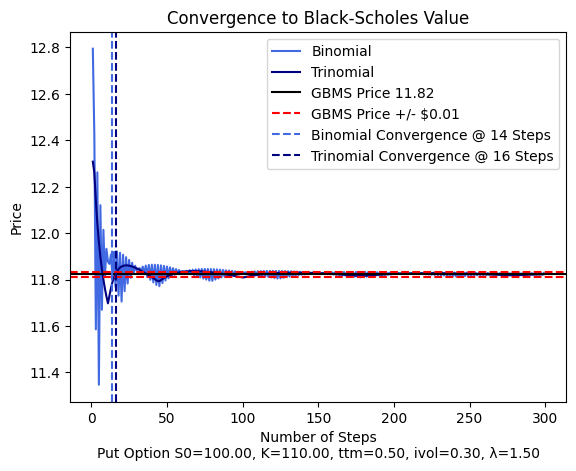

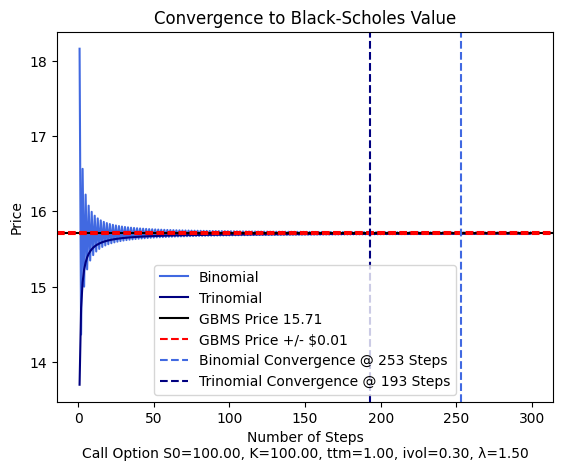

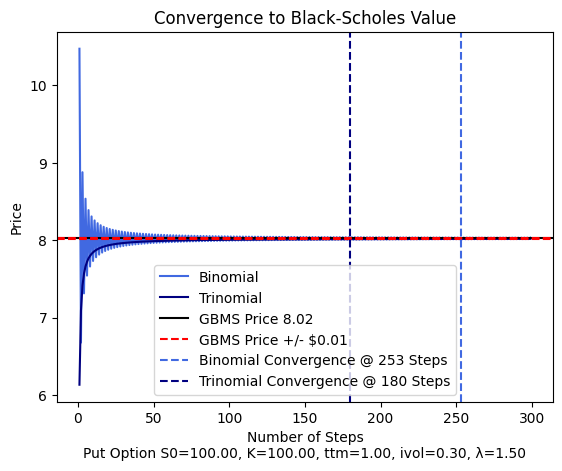

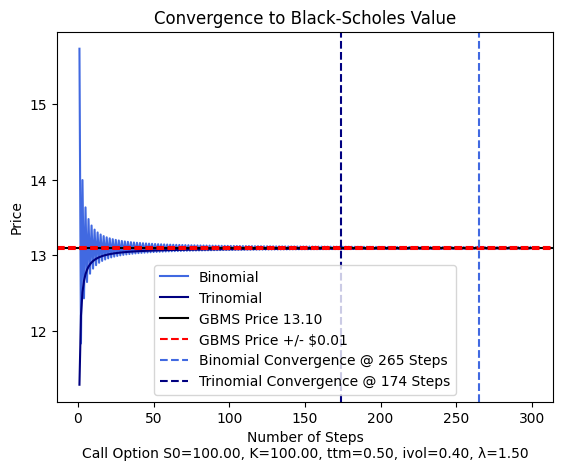

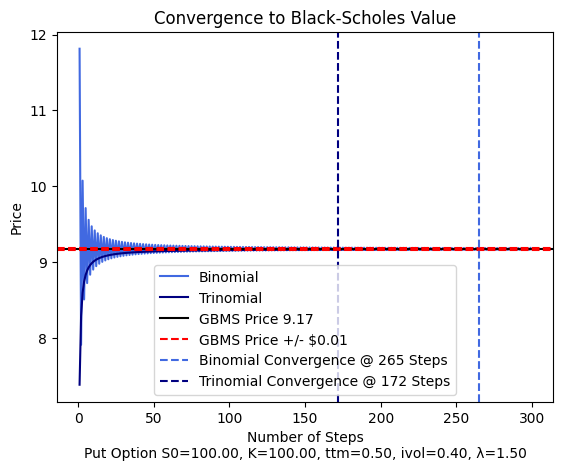

In [225]:
option_type = "put"
underlying_price = 100.0
strike_price = 100.0
ttm = 0.5          
rf = 0.08         
b = 0.08          
q = 0
ivol = 0.3        
lamda = 1.5

convergence_test("call", underlying_price, strike_price, ttm, rf, b, q, ivol, lamda)
convergence_test("put", underlying_price, strike_price, ttm, rf, b, q, ivol)
convergence_test("call", 110, strike_price, ttm, rf, b, q, ivol)
convergence_test("put", 110, strike_price, ttm, rf, b, q, ivol)
convergence_test("call", underlying_price, 110, ttm, rf, b, q, ivol)
convergence_test("put", underlying_price, 110, ttm, rf, b, q, ivol)
convergence_test("call", underlying_price, strike_price, 1, rf, b, q, ivol)
convergence_test("put", underlying_price, strike_price, 1, rf, b, q, ivol)
convergence_test("call", underlying_price, strike_price, ttm, rf, b, q, 0.4)
convergence_test("put", underlying_price, strike_price, ttm, rf, b, q, 0.4)